### Topics

- Requests and getting webpages
- Tidying HTML
- Web Scraping with BS
    - Traversal
- simple parallelization
- Storing Snapshots by using python dill
- Exploration
- Stock selection using simple filters

### Imports

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_seq_items', None)
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [7]:
np.set_printoptions(threshold=np.nan)

import warnings
import traceback

warnings.filterwarnings('ignore')
import argparse
import re
import sys, os

sys.path.append(os.getcwd())

import os
import requests
from requests.exceptions import ConnectionError

import bs4
from bs4 import BeautifulSoup
from fastnumbers import isfloat
from fastnumbers import fast_float
from multiprocessing.dummy import Pool as ThreadPool 
import more_itertools
from random import shuffle

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
import json

import seaborn as sns
sns.set_style('whitegrid')





### Libs

In [8]:
def is_dataframe(df):
    if df is not None and type(df)==pd.core.frame.DataFrame:
        return True
    return False

def ffloat(string):
    if string is None:
        return np.nan
    if type(string)==float or type(string)==int or type(string)==np.int64 or type(string)==np.float64:
        return string
    return fast_float(string.split(" ")[0].replace(',','').replace('%',''),default=np.nan)

def ffloat_list(string_list):
    return list(map(ffloat,string_list))


def get_children(html_content):
    return [item for item in html_content.children if type(item)==bs4.element.Tag]


def get_table(portfolio_table):
    portfolio_elems = get_children(portfolio_table)

    table_data = list()
    for row in portfolio_elems:
        row_data = list()
        row_elems = get_children(row)
        for elem in row_elems:
            text = elem.text.strip().replace("\n","")
            if len(text)==0:
                continue
            elem_descriptor = {'text':text}
            elem_children = get_children(elem)
            if len(elem_children)>0:
                if elem_children[0].has_attr('href'):
                    elem_href = elem_children[0]['href']
                    elem_descriptor['href'] = elem_href

            row_data.append(elem_descriptor)
        table_data.append(row_data)
    return table_data

def get_table_simple(portfolio_table,is_table_tag=True):
    portfolio_elems = portfolio_table.find_all('tr')
    table_data = list()
    for row in portfolio_elems:
        row_data = list()
        row_elems = get_children(row)
        #print(row_elems)
        for elem in row_elems:
            text = elem.text.strip().replace("\n","")
            if len(text)==0:
                continue
            row_data.append(text)
        table_data.append(row_data)
    return table_data

def get_inner_texts_as_array(elem,filter_empty=True):
    
    children = get_children(elem)
    tarr = [child.text.strip().replace("\n","") for child in children]
    if filter_empty:
        tarr = list(filter(lambda x:x is not None and len(x)>0,tarr))
    return tarr
        

In [9]:

def get_ratios(url):
    page_response = requests.get(url, timeout=240)
    page_content = BeautifulSoup(page_response.content, "html.parser")
    table_content = page_content.find_all('table',attrs={'class':'table4'})[-1]
    if "Data Not Available" in table_content.text:
         return {}
    dates_html = get_children(get_children(get_children(table_content)[0])[1])[1]
    
    dates = get_inner_texts_as_array(dates_html)
    
    ratios_htmls = get_children(get_children(get_children(get_children(table_content)[0])[1])[2])[1:]
        
    rows = list(map(get_inner_texts_as_array,ratios_htmls))
    ratios = {}
    ratios['dates'] = dates
    
    for row in rows:
        if len(row)>1:
            ratios[row[0]] = ffloat_list(row[1:])
    
    needed_keys = [('dates','ratios_dates'),
                   ('Diluted EPS (Rs.)','ratios_diluted_eps'),
                   ('Revenue from Operations/Share (Rs.)','ratios_revenue_per_share'),
                   ('PBT/Share (Rs.)','ratios_pbt_per_share'),
                   ('PBT Margin (%)','ratios_pbt_margin_per_share'),
                   ('Total Debt/Equity (X)','ratios_de'),
                   ('Asset Turnover Ratio (%)','ratios_asset_turnover_ratio'),
                   ('Current Ratio (X)','ratios_cr'),
                   ('EV/EBITDA (X)','ratios_ev_by_ebitda'),
                   ('Price/BV (X)','ratios_pb')]
    
    ratios = { your_key[1]: ratios[your_key[0]] if your_key[0] in ratios else [] for your_key in needed_keys }
    return ratios

In [10]:


def get_past_prices(sc_id):
    bse_url = "https://www.moneycontrol.com/tech_charts/bse/his/%s.csv"%sc_id
    nse_url = "https://www.moneycontrol.com/tech_charts/nse/his/%s.csv"%sc_id
    
    past_prices_nse = pd.read_csv(nse_url,header=None,names=['open','high','low','close','volume',1,2,3,4])[['open','high','low','close','volume']]
    past_prices_nse.index = pd.to_datetime(past_prices_nse.index)
    
    past_prices_bse = pd.read_csv(bse_url,header=None,names=['open','high','low','close','volume',1,2,3,4])[['open','high','low','close','volume']]
    past_prices_bse.index = pd.to_datetime(past_prices_bse.index)
    
    
    if len(past_prices_nse)>=len(past_prices_bse):
        past_prices = past_prices_nse
    else:
        past_prices = past_prices_bse
    return past_prices

### Lib for fetching

In [11]:

def get_scrip_info(url):
    original_url = url
    key_val_pairs = {}
    key_val_pairs["original_url"] = original_url
    if not url.startswith("http"):
        url = "https://www.moneycontrol.com"+url
    try:
        page_response = requests.get(url, timeout=240)
        page_content = BeautifulSoup(page_response.content, "html.parser")
        scrip_name = None
        name_divs = page_content.find_all('div',attrs={'class':'gry10'})
        for nd in name_divs:
            texts = list(map(lambda x:x.strip(),nd.text.split(" ")))
            if "NSE:" in texts:
                scrip_name = texts[texts.index("NSE:")+1]
                scrip_name = re.sub('[^0-9a-zA-Z&\-]+', '', scrip_name)
        if "ETF" in scrip_name:
            key_val_pairs['failure'] = True
            key_val_pairs['err'] = "%s is an ETF"%url
            #print(key_val_pairs['err'])
            return key_val_pairs
        
        content_div_text = page_content.find('div',attrs={'id':'content_full'}).text
        if "not listed" in content_div_text or "not traded" in content_div_text:
            key_val_pairs['failure'] = True
            key_val_pairs['err'] = "%s is not listed on both BSE and NSE"%url
            
            return key_val_pairs
        price = ffloat(page_content.find('div',attrs={'id':'Nse_Prc_tick_div'}).text.split(" ")[0].replace(',',''))
        name = page_content.find('h1',attrs={'class':'company_name'}).text
        
        yearly_high = page_content.find('span',attrs={'id':'n_52high'}).text.strip()
        yearly_low = page_content.find('span',attrs={'id':'n_52low'}).text.strip()
        html_data_content = page_content.find('div', attrs={'id': 'mktdet_1'})
        petable = get_table(get_children(html_data_content)[0])
        pbtable = get_table(get_children(html_data_content)[1])
        
        
        dma_table = get_table_simple(page_content.find('div',attrs={'id':'acc_hd2'}).find_all('table')[2])
        thirty_dma = None
        fifty_dma = None
        one_fifty_dma = None
        two_hundred_dma = None
        if len(dma_table[1])>1:
            thirty_dma = dma_table[1][1]
        if len(dma_table[2])>1:
            fifty_dma = dma_table[2][1]
        if len(dma_table[3])>1:
            one_fifty_dma = dma_table[3][1]
        if len(dma_table[4])>1:
            two_hundred_dma = dma_table[4][1]
        
        
        side_nav = page_content.find('dl',attrs={'id':'slider'})
        ratio_url = side_nav.find_all('dd')[2].find_all('a')[7]['href']
        ratio_url = "https://www.moneycontrol.com"+ratio_url
        ratios = get_ratios(ratio_url)
        
        
        volume = ffloat(page_content.find('span',attrs={'id':'nse_volume'}).text)
        
        sc_id = page_content.find('input',attrs={'id':'sc_id'}).get('value').lower()
        
        key_val_pairs = {**key_val_pairs, **ratios}
        
        past_prices = get_past_prices(sc_id)
        
        data_table = list()
        data_table.extend(petable)
        data_table.extend(pbtable)

        consolidated_html_data_content = page_content.find('div', attrs={'id': 'mktdet_2'})
        consolidated_petable = get_table(get_children(consolidated_html_data_content)[0])
        consolidated_pbtable = get_table(get_children(consolidated_html_data_content)[1])
        consolidated_data_table = list()
        consolidated_data_table.extend(consolidated_petable)
        consolidated_data_table.extend(consolidated_pbtable)

        

        for row in consolidated_data_table:

            k = row[0]['text']
            if len(row)<2:
                v=None
            else:
                v = row[1]['text'].split(" ")[0].replace(',','')
            key_val_pairs[k]=v

        for row in data_table:

            k = row[0]['text']
            if len(row)<2:
                v=None
            else:
                v = row[1]['text'].split(" ")[0].replace(',','')

            if k not in key_val_pairs or not isfloat(key_val_pairs[k]):
                key_val_pairs[k]=v

        key_val_pairs["pe"] = ffloat(key_val_pairs.pop('P/E'))
        key_val_pairs["book_value"] = ffloat(key_val_pairs.pop('BOOK VALUE (Rs)'))
        key_val_pairs["deliverables"] = ffloat(key_val_pairs.pop('DELIVERABLES (%)'))
        key_val_pairs["eps"] = ffloat(key_val_pairs.pop('EPS (TTM)'))
        key_val_pairs["industry_pe"] = ffloat(key_val_pairs.pop('INDUSTRY P/E'))
        if 'MARKET CAP (Rs Cr)' in key_val_pairs:
            key_val_pairs["market_cap"] = key_val_pairs.pop('MARKET CAP (Rs Cr)')
        elif '**MARKET CAP (Rs Cr)' in key_val_pairs:
            key_val_pairs["market_cap"] = key_val_pairs.pop('**MARKET CAP (Rs Cr)')
        key_val_pairs["market_cap"] = ffloat(key_val_pairs["market_cap"])
        key_val_pairs["pb"] = ffloat(key_val_pairs.pop('PRICE/BOOK'))
        key_val_pairs["pc"] = ffloat(key_val_pairs.pop('P/C'))
        key_val_pairs['price'] = ffloat(price)
        key_val_pairs['volume'] = volume
        key_val_pairs["name"] = name
        key_val_pairs["scrip_name"] = scrip_name
        key_val_pairs["yearly_low"] = ffloat(yearly_low)
        key_val_pairs["yearly_high"] = ffloat(yearly_high)

        key_val_pairs['thirty_dma'] = ffloat(thirty_dma)
        key_val_pairs['fifty_dma'] = ffloat(fifty_dma)
        key_val_pairs['one_fifty_dma'] = ffloat(one_fifty_dma)
        key_val_pairs['two_hundred_dma'] = ffloat(two_hundred_dma)
        key_val_pairs['past_prices'] = past_prices
        key_val_pairs['de'] = np.nan
        key_val_pairs['ev_by_ebitda'] = np.nan
        if "ratios_ev_by_ebitda" in key_val_pairs and len(key_val_pairs["ratios_ev_by_ebitda"])>0:
            key_val_pairs['ev_by_ebitda'] = key_val_pairs["ratios_ev_by_ebitda"][0]
        
        if "ratios_de" in key_val_pairs and len(key_val_pairs["ratios_de"])>0:
            key_val_pairs['de'] = key_val_pairs["ratios_de"][0]
        key_val_pairs['failure'] = False

        del key_val_pairs['DIV (%)']
        del key_val_pairs['DIV YIELD.(%)']
        del key_val_pairs['FACE VALUE (Rs)']
        del key_val_pairs['Market Lot']
    except Exception as e:
#         raise e
        traceback.print_exc()
        key_val_pairs['failure'] = True
        key_val_pairs['err'] = "Error for: %s"%original_url
        print(key_val_pairs['err'])
        return key_val_pairs
        
    return key_val_pairs


In [12]:
def get_scrip_info_by_nse_name(nse_name):
    url = "https://www.moneycontrol.com/mccode/common/autosuggesion.php?classic=true&query=%s&type=1&format=json"%nse_name
    page_response = requests.get(url, timeout=240)
    json_text = page_response.text
    data = json.loads(json_text)
    if len(data)>1:
        key_val_pairs = {}
        key_val_pairs['failure'] = True
        key_val_pairs['err'] = "Search unsuccessful for %s"%nse_name
    scrip_url = data[0]['link_src']
    return get_scrip_info(scrip_url)

### Company Analysis and Filtering 



#### Generic Filter one variable upper lower limits

In [13]:
def get_generic_filter(param_name,lower_limit=None,upper_limit=None,
                                     replacement_nan=None,replacement_not_present=None):
    def filter_fn(stock_detail):
        param = replacement_not_present
        if param_name in stock_detail:
            param = ffloat(stock_detail[param_name])
            
        if np.isnan(param):
            param = replacement_nan
        
        if param is None or np.isnan(param):
            return False
        
        if param<=upper_limit and param>=lower_limit:
            return True
        return False
        
    return filter_fn

In [16]:
def get_all_company_details(nse_names,
                            threadpool_size=8):
    # filters is a list of functions returning T/F, They are always
    batch_size = 5*threadpool_size
    pool = ThreadPool(threadpool_size)
    scrip_details = pool.map(get_scrip_info_by_nse_name, nse_names)
    failures = list(filter(lambda x:x['failure'],scrip_details))
    successes = list(filter(lambda x:not x['failure'],scrip_details))
    successes={scrip['scrip_name']:scrip for scrip in successes}
    return successes,failures


In [18]:
some_nse_companies = ["AARTIDRUGS","ATUL","AUROPHARMA","AXISBANK","BAJAJ-AUTO","BANKBARODA",
                     "BHEL","DABUR","DBCORP","DIVISLAB","EVEREADY","EICHERMOT",
                     "GLENMARK","GREAVESCOT","HDFC","HDFCBANK","INDIABULLS","ITC","KOTAKBANK","KEC"]
successes,failures = get_all_company_details(some_nse_companies,
                        threadpool_size=4);

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHA

In [19]:
len(successes.keys())
len(failures)

17

3

#### Write to File

In [ ]:

import dill
with open('tutorial_results.pkl', 'wb') as f:
    dill.dump(accumulator, f)
    dill.dump(failures, f)

#### Read from File 

In [ ]:
import dill
with open('tutorial_results.pkl', 'rb') as f:
    accumulator = dill.load(f)
    failures = dill.load(f)

### Portfolio Selection based on Data

In [20]:
def filter_companies(all_scrips,filters=[]):
    scrip_details = list(all_scrips.values())
    
    for i in range(len(filters)):
        scrip_details = list(filter(filters[i],scrip_details))
    
    return scrip_details
    
    

In [21]:
def get_df_from_scrip_details(scrip_details):
    other_cols = ['name','scrip_name']
    numeric_cols = ['book_value', 'price','deliverables', 'eps', 'industry_pe', 
                    'market_cap', 'pb', 'pc', 'pe','de',
                   'yearly_high','yearly_low']
    
    
    all_cols = other_cols+numeric_cols
    scrip_details = [{ your_key: scrip[your_key] for your_key in all_cols } for scrip in scrip_details]
    scrip_details = pd.DataFrame.from_records(scrip_details)
    scrip_details[numeric_cols] = scrip_details[numeric_cols].applymap(ffloat)
    scrip_details = scrip_details[all_cols]
    return scrip_details

In [22]:
pe_filter = get_generic_filter("pe",lower_limit=0,upper_limit=20,
                                     replacement_nan=-1,replacement_not_present=-1)
pb_filter = get_generic_filter("pb",lower_limit=0,upper_limit=4,
                                     replacement_nan=-1,replacement_not_present=-1)
filtered_companies = filter_companies(accumulator,filters=[pe_filter,pb_filter])
get_df_from_scrip_details(filtered_companies)

,name,scrip_name,book_value,price,deliverables,eps,industry_pe,market_cap,pb,pc,pe,de,yearly_high,yearly_low
0,Aarti Drugs Ltd.,AARTIDRUGS,208.95,552.70,65.40,34.90,29.03,1300.20,2.64,10.63,15.80,1.11,785.00,485.00
1,Aurobindo Pharma Ltd.,AUROPHARMA,201.34,591.05,23.77,41.36,29.03,34638.86,2.94,11.62,14.29,0.34,809.45,527.00
2,Bajaj Auto Ltd.,BAJAJ-AUTO,705.86,2686.75,32.93,152.89,19.65,77493.93,3.79,16.35,17.52,0.00,3468.35,2605.00
3,DB Corp Ltd.,DBCORP,104.23,249.75,61.27,16.92,13.91,4618.16,2.41,11.44,14.83,0.04,388.00,235.00
4,Greaves Cotton Ltd.,GREAVESCOT,39.51,143.75,78.25,8.30,24.11,3511.69,3.64,13.77,17.33,NaN,164.95,112.35


In [23]:
de_filter = get_generic_filter("de",lower_limit=0,upper_limit=1,
                                     replacement_nan=0,replacement_not_present=0)
filtered_companies = filter_companies(accumulator,filters=[pe_filter,pb_filter,de_filter])
get_df_from_scrip_details(filtered_companies)

,name,scrip_name,book_value,price,deliverables,eps,industry_pe,market_cap,pb,pc,pe,de,yearly_high,yearly_low
0,Aurobindo Pharma Ltd.,AUROPHARMA,201.34,591.05,23.77,41.36,29.03,34638.86,2.94,11.62,14.29,0.34,809.45,527.00
1,Bajaj Auto Ltd.,BAJAJ-AUTO,705.86,2686.75,32.93,152.89,19.65,77493.93,3.79,16.35,17.52,0.00,3468.35,2605.00
2,DB Corp Ltd.,DBCORP,104.23,249.75,61.27,16.92,13.91,4618.16,2.41,11.44,14.83,0.04,388.00,235.00
3,Greaves Cotton Ltd.,GREAVESCOT,39.51,143.75,78.25,8.30,24.11,3511.69,3.64,13.77,17.33,NaN,164.95,112.35


In [24]:
def score_company_on_filters(all_scrips,filters={}):
    all_scrips = list(all_scrips.values())
    other_cols = ['name','scrip_name']
    numeric_cols = ['price', 
                    'market_cap', 'pb', 'pe','de',
                   'yearly_high','yearly_low']
    all_cols = other_cols+list(filters.keys())+numeric_cols
    scrip_details = []
    for scrip in all_scrips:
        for key in filters.keys():
            scrip[key] = filters[key](scrip)
        scrip_detail = { your_key: scrip[your_key] for your_key in all_cols }
        
        scrip_details.append(scrip_detail)
        
    scrip_details = pd.DataFrame.from_records(scrip_details)
    scrip_details[numeric_cols] = scrip_details[numeric_cols].applymap(ffloat)
    scrip_details = scrip_details[all_cols]
    return scrip_details
    

In [25]:
scores_df = score_company_on_filters(accumulator,filters={"pe_filter":pe_filter,"pb_filter":pb_filter,"de_filter":de_filter})

In [26]:
scores_df

,name,scrip_name,pe_filter,pb_filter,de_filter,price,market_cap,pb,pe,de,yearly_high,yearly_low
0,Aarti Drugs Ltd.,AARTIDRUGS,True,True,False,552.70,1300.20,2.64,15.80,1.11,785.00,485.00
1,Atul Ltd.,ATUL,False,True,True,2740.70,8103.44,3.58,25.31,0.00,3094.70,1950.00
2,Aurobindo Pharma Ltd.,AUROPHARMA,True,True,True,591.05,34638.86,2.94,14.29,0.34,809.45,527.00
3,Axis Bank Ltd.,AXISBANK,False,True,True,553.25,142176.80,2.21,517.43,NaN,627.60,447.50
4,Bajaj Auto Ltd.,BAJAJ-AUTO,True,True,True,2686.75,77493.93,3.79,17.52,0.00,3468.35,2605.00
5,Bank Of Baroda,BANKBARODA,False,True,True,137.85,36521.35,0.78,NaN,NaN,206.65,109.50
6,Bharat Heavy Electricals Ltd.,BHEL,False,True,True,71.15,26122.01,0.81,29.65,0.00,107.95,64.45
7,Dabur India Ltd.,DABUR,False,False,True,386.00,68071.83,11.87,50.25,0.07,396.40,296.50
8,DB Corp Ltd.,DBCORP,True,True,True,249.75,4618.16,2.41,14.83,0.04,388.00,235.00
9,Divis Laboratories Ltd.,DIVISLAB,False,False,True,1103.00,29229.42,4.69,33.61,0.01,1223.00,611.00


### Plotting and Analysis

#### PE vs MarketCap Corr

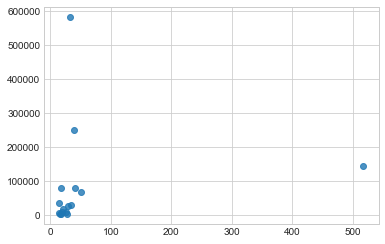

In [27]:
pe_list = []
mcap_list = []
for key in accumulator.keys():
    prices_df = accumulator[key]['past_prices']
    
    pe = accumulator[key]['pe']
    mcap = accumulator[key]['market_cap']
    
    pe_list.append(pe)
    mcap_list.append(mcap)
    
ax = sns.regplot(x=np.array(pe_list), y=np.array(mcap_list),fit_reg=False)
# ax.set_xlim([1,50])
# ax.set_ylim([10000,800000])
plt.show()

#### Price Volume Charts

In [28]:

def generate_price_volume_chart(stock_df,name,days=1095,ewmas=[],other_technical_indicators=[]):
    plt.figure(figsize=(16,8))
    top = plt.subplot2grid((6,6), (0, 0), rowspan=4, colspan=6)
    bottom = plt.subplot2grid((6,6), (4,0), rowspan=2, colspan=6)
    ts_df = stock_df.tail(days)
    handles = []
    p1, = top.plot(ts_df.index, ts_df['close'],label="price")
    handles.append(p1)
    for ewma in ewmas:
        y = ts_df['close'].ewm(span=ewma).mean()
        p2, = top.plot(ts_df.index, y,label="%s day ewma"%ewma)
        handles.append(p2)
    top.legend(handles=handles)
    bottom.bar(ts_df.index, ts_df['volume']) 
    bottom.set_ylim([ts_df['volume'].min(),ts_df['volume'].max()])
#     sns.lineplot(x="index", y="close", data=ts_df.reset_index(),ax=top)
#     sns.barplot(x="index", y="volume", data=ts_df.reset_index(),ax=bottom)

    # set the labels
    top.axes.get_xaxis().set_visible(False)
    top.set_title(name)
    top.set_ylabel('Closing Price')
    bottom.set_ylabel('Volume')
    
    plt.show()

In [29]:
hero = get_scrip_info_by_nse_name('HEROMOTOCO')
exide = get_scrip_info_by_nse_name('EXIDEIND')

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


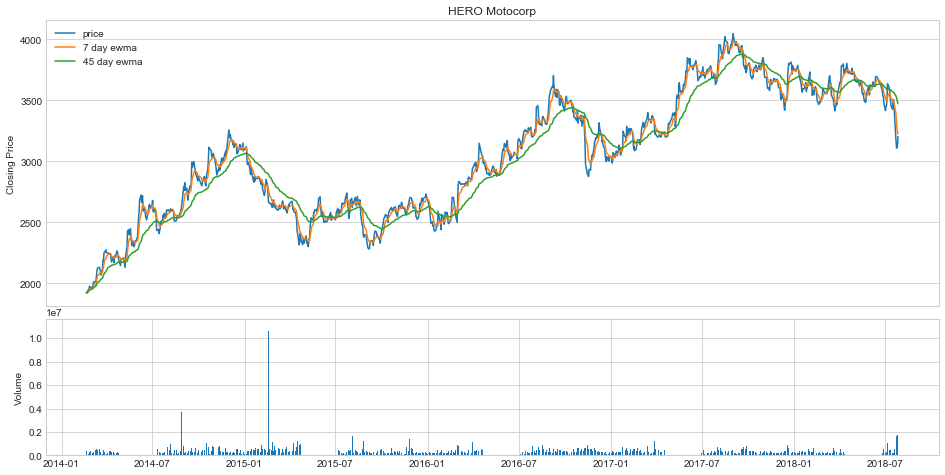

In [30]:
generate_price_volume_chart(hero['past_prices'],"HERO Motocorp",days=1095,ewmas=[7,45])

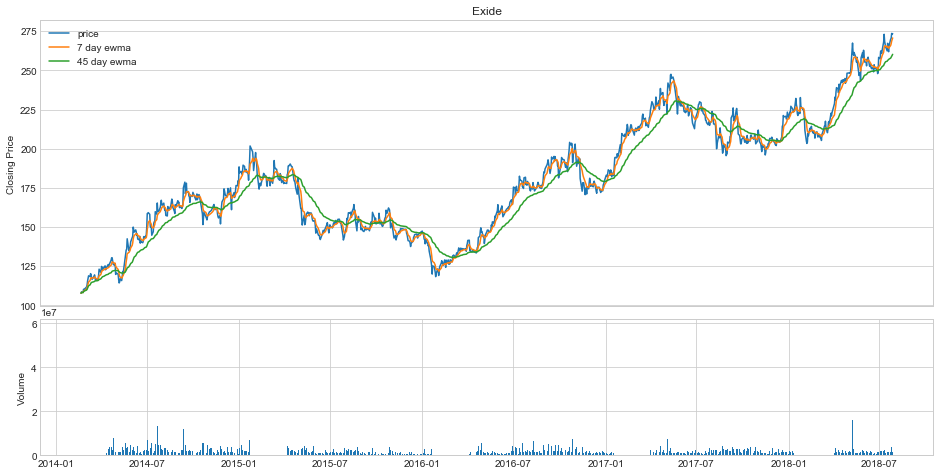

In [31]:
generate_price_volume_chart(exide['past_prices'],"Exide",days=1095,ewmas=[7,45])


#### Returns analysis

In [32]:

def generate_returns_chart(stocks,days=1095):
    plt.figure(figsize=(16,8))
    stocks = {key:stocks[key].tail(days).apply(lambda x: x / x[0]) for key in stocks.keys()}
    handles = []
    for key in stocks.keys():
        y = stocks[key]['close']
        p2, = plt.plot(stocks[key].index, y,label=key)
        handles.append(p2)
    plt.legend(handles=handles)
    plt.title("Comparative returns")
    plt.ylabel('Comparative Returns')
    
    plt.show()

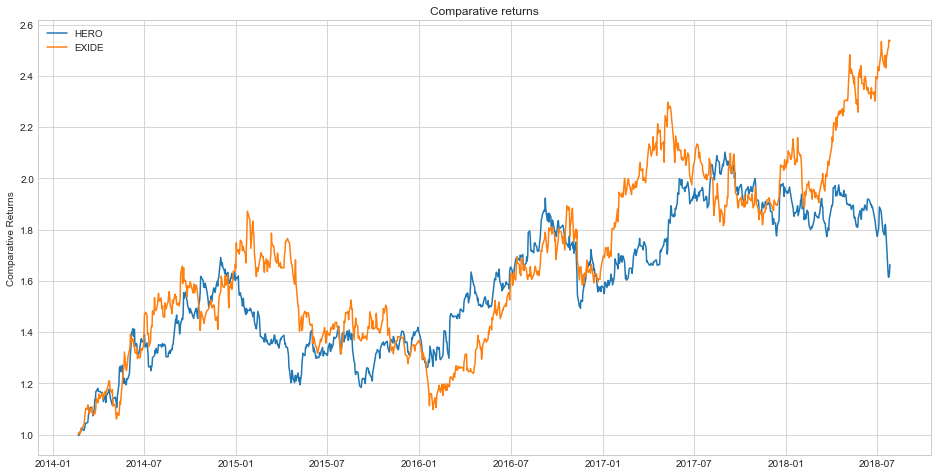

In [33]:
generate_returns_chart({"HERO":hero['past_prices'],
                       "EXIDE":exide['past_prices']})

#### Volatility analysis

In [34]:
def generate_percent_change_chart(stocks,days=1095):
    plt.figure(figsize=(16,8))
    stocks = {key:stocks[key].tail(days).pct_change()*100 for key in stocks.keys()}
    handles = []
    for key in stocks.keys():
        stocks[key]['name'] = key
        y = stocks[key]['close']
        p2, = plt.plot(stocks[key].index, y,label=key)
        handles.append(p2)
    all_stocks = pd.concat(list(stocks.values()))
    plt.legend(handles=handles)
    plt.title("Daily Percent Changes Chart")
    plt.ylabel('Daily Percent Changes')
    plt.show()
    fig, ax = plt.subplots(figsize=(16,8))
    sns.boxplot(x="name", y="close", data=all_stocks,ax=ax);
    ax.xaxis.set_tick_params(rotation=90)
    plt.show()

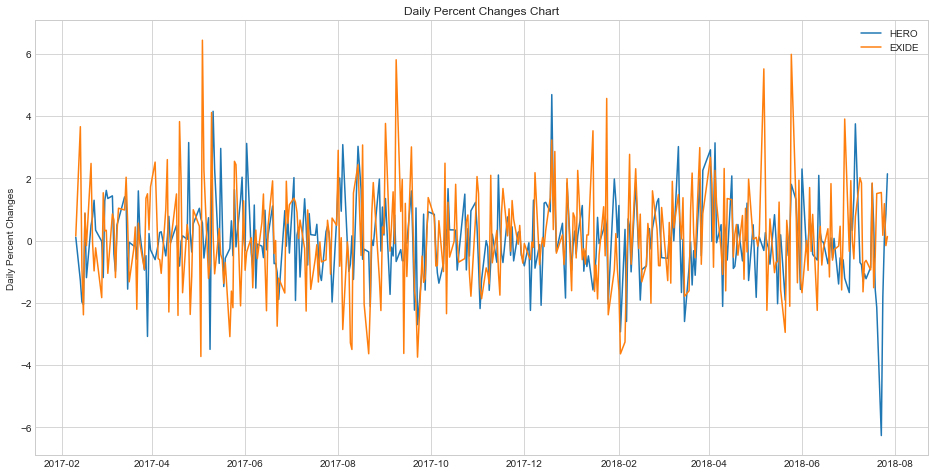

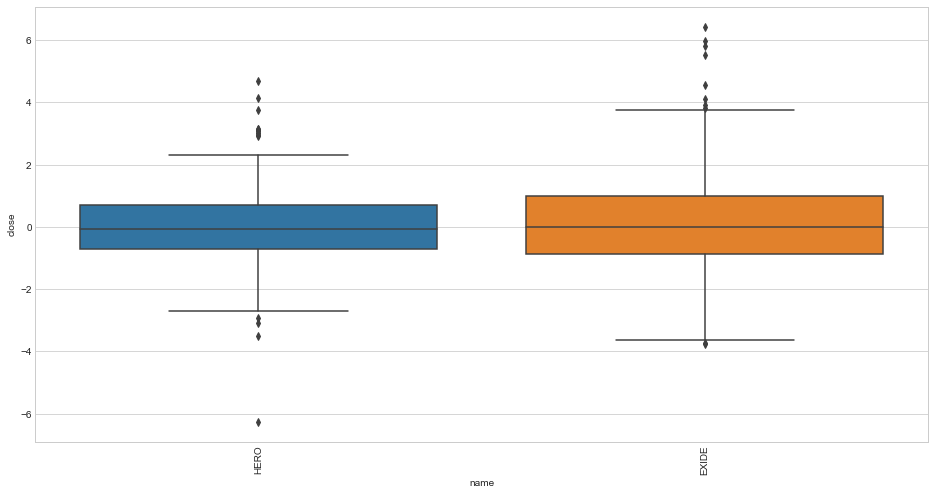

In [35]:

generate_percent_change_chart({"HERO":hero['past_prices'],
                       "EXIDE":exide['past_prices']},days=365)

#### Returns and Volatility of all companies we used

In [36]:
all_scrip_prices_df = {scrip["scrip_name"]:scrip['past_prices'] for scrip in accumulator.values()}


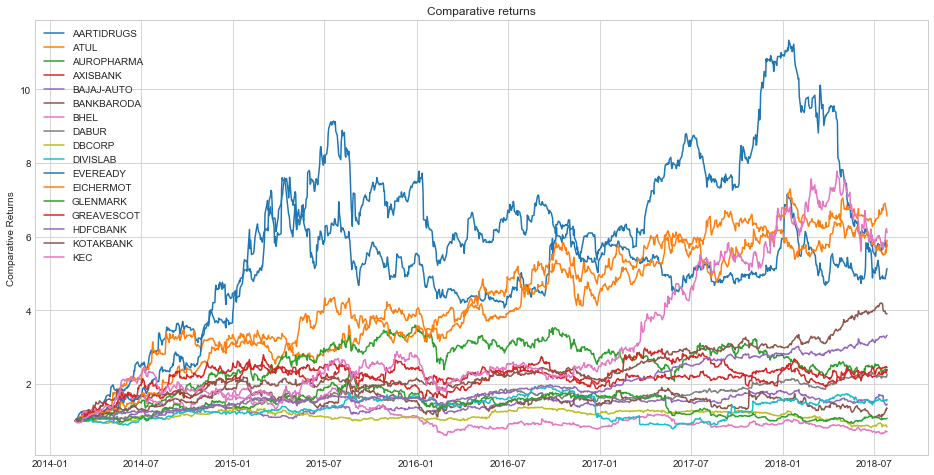

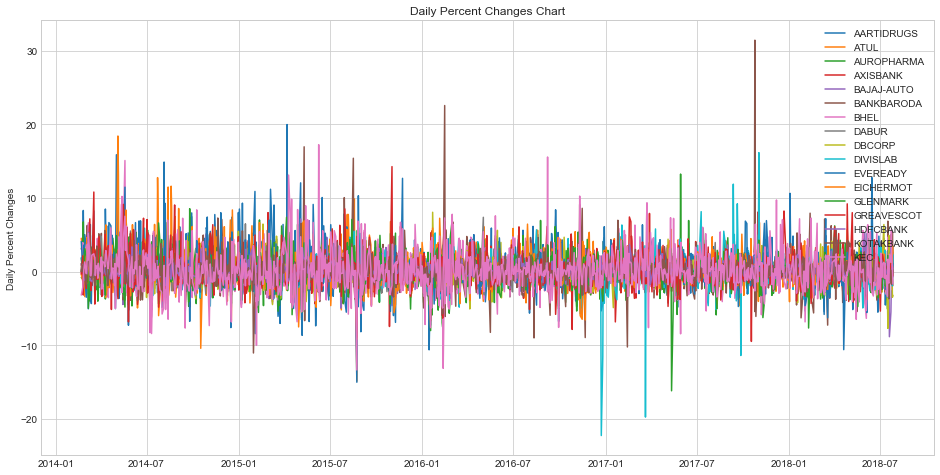

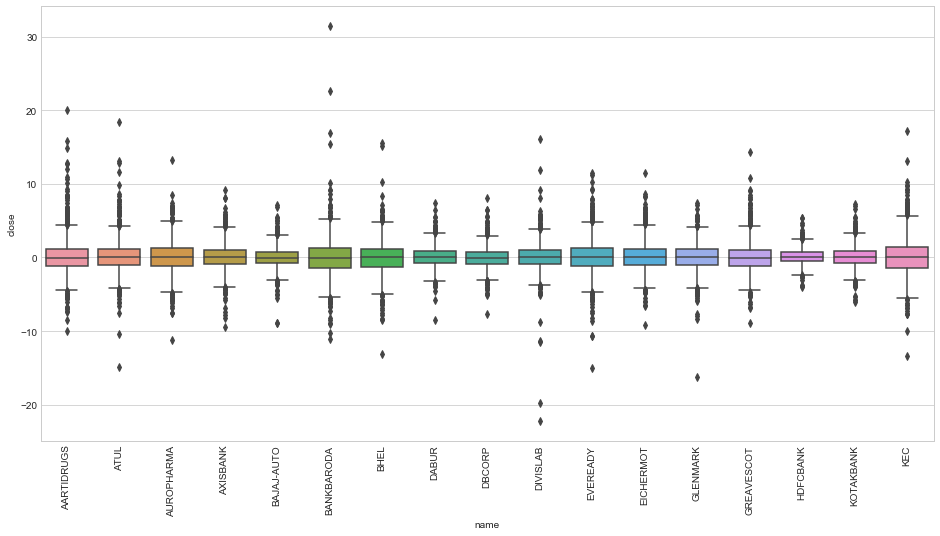

In [37]:
generate_returns_chart(all_scrip_prices_df)
generate_percent_change_chart({scrip["scrip_name"]:scrip['past_prices'] for scrip in accumulator.values()})

#### Nifty 50, Nifty 100, Nifty midcap 50 Analysis

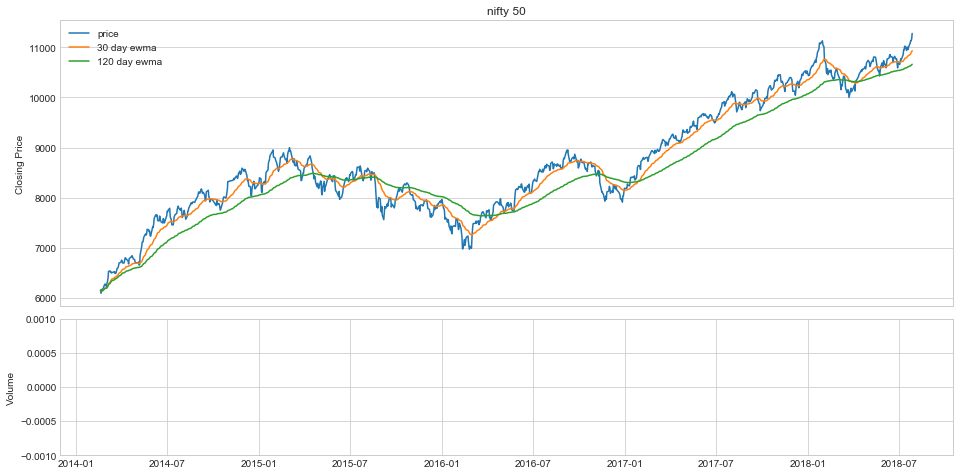

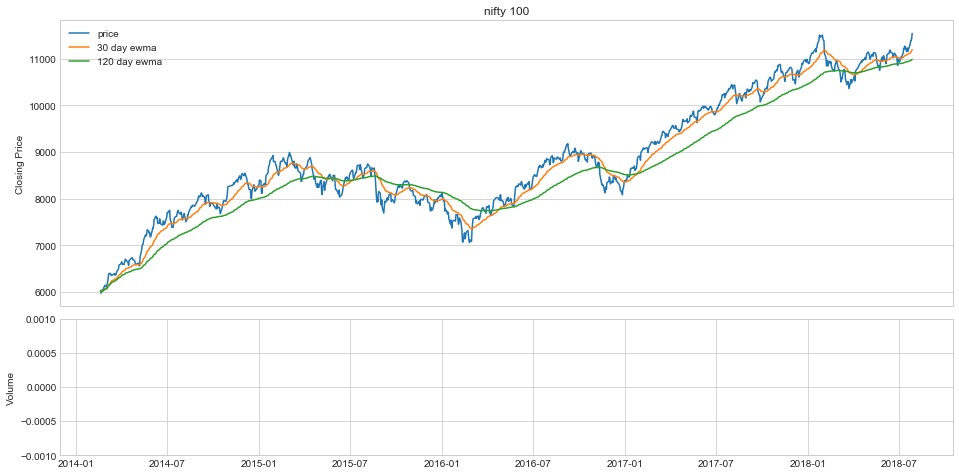

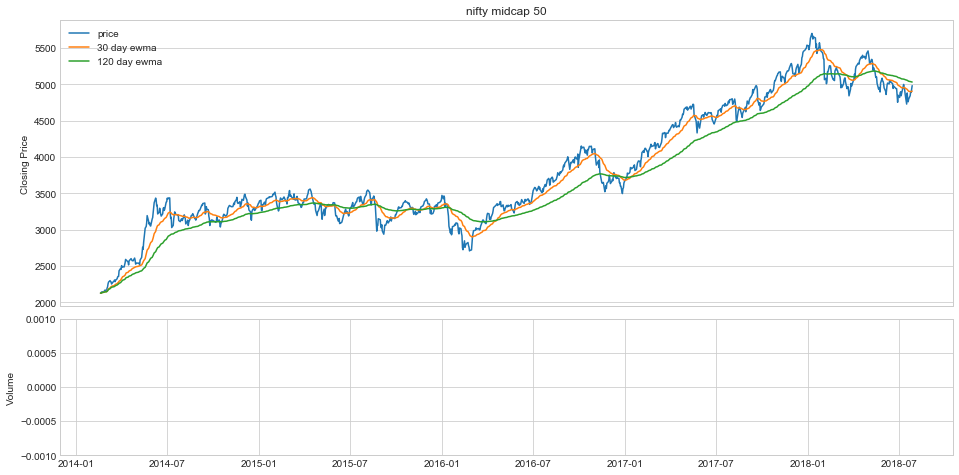

In [77]:
n50_url = "http://www.moneycontrol.com/tech_charts/nse/his/nifty.csv"
n50 = pd.read_csv(n50_url,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
n50.index = pd.to_datetime(n50.index)


n100_url = "http://www.moneycontrol.com/tech_charts/nse/his/cnx_100.csv"
n100 = pd.read_csv(n100_url,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
n100.index = pd.to_datetime(n100.index)

nmid_url = "http://www.moneycontrol.com/tech_charts/nse/his/nifty_midcap_50.csv"
nmid = pd.read_csv(nmid_url,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
nmid.index = pd.to_datetime(nmid.index)



generate_price_volume_chart(n50,"nifty 50",days=1095,ewmas=[30,120])
generate_price_volume_chart(n100,"nifty 100",days=1095,ewmas=[30,120])
generate_price_volume_chart(nmid,"nifty midcap 50",days=1095,ewmas=[30,120])


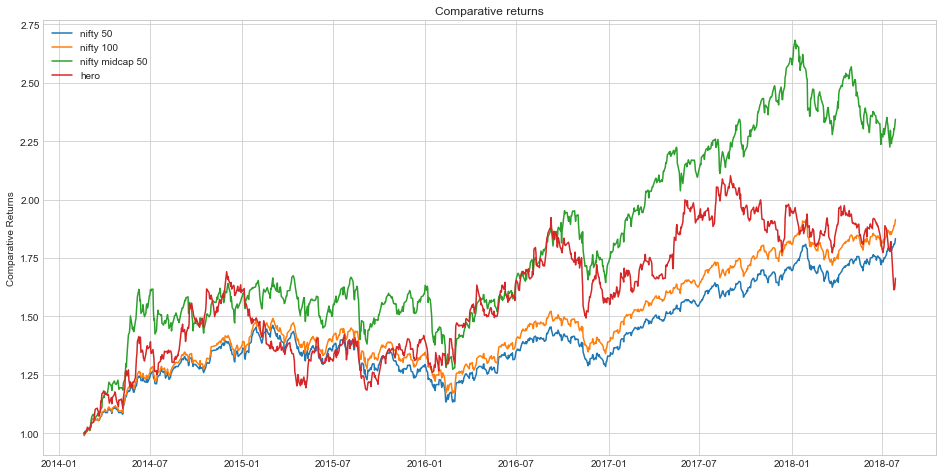

In [80]:
generate_returns_chart({"nifty 50":n50,"nifty 100":n100,"nifty midcap 50":nmid,"hero":hero['past_prices']['all_past_prices']})

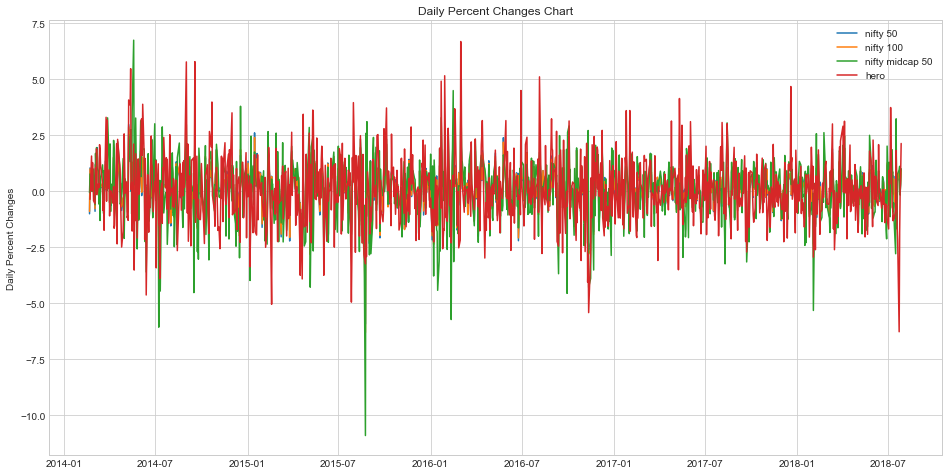

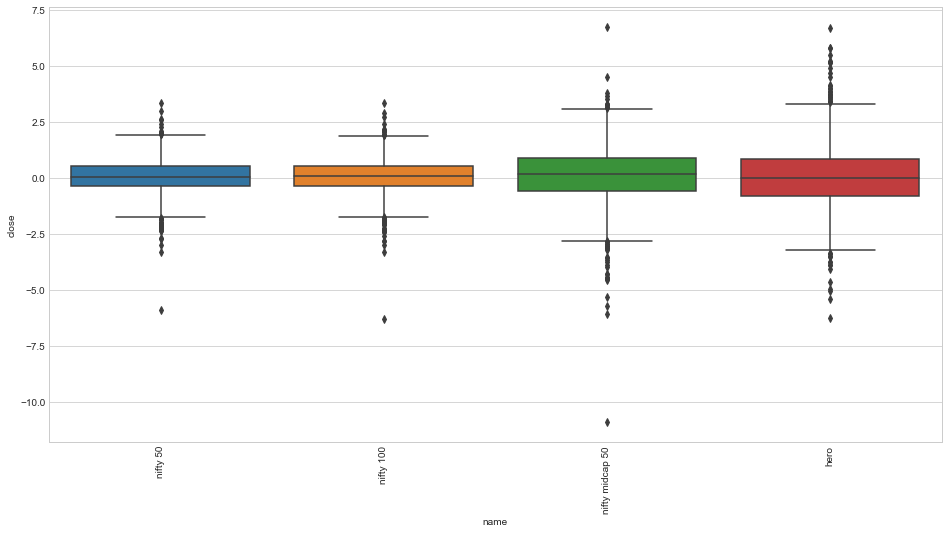

In [79]:



generate_percent_change_chart({"nifty 50":n50,"nifty 100":n100,"nifty midcap 50":nmid,"hero":hero['past_prices']['all_past_prices']},days=1095)


### References

- https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/
- https://mapattack.wordpress.com/2017/02/14/python-for-stocks-2/

more involved articles:

 - https://ntguardian.wordpress.com/2018/07/17/stock-data-analysis-python-v2/
 - https://nextjournal.com/hisham/stock-market
 